# **TECNICATURA UNIVERSITARIA EN INTELIGENCIA ARTIFICIAL**  
## TRABAJO PRÁCTICO N° 3: MINERÍA DE DATOS  
### **INTEGRANTES:** Caballero, Franco - (C-7328/8) | Rosito, Valentin - (R-4662/1)
### **Fecha Límite de Entrega:** 6/06/2025  
### **Semestre:** 1° Semestre 2025


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC


# Ejercicio 1: EDA 

**VARIABLES**  

Temperatura → Temperatura diaria registrada (en grados Celsius).  
Humedad → Porcentaje de humedad relativa en el ambiente.  
VientoVelocidad → Velocidad del viento (en km/h).  
Precipitation → Precipitación diaria acumulada (en mm).  
PresionAtmosferica → Presión atmosférica medida (en hPa).  
Localizacion → Ubicación geográfica donde se tomaron las mediciones (Llanura, Montaña, Costa).  
TipoClima → Clasificación climática general del día (Soleado, Lluvioso, Nublado, Nevado).  

**TARGET**
  
Estacion → Estación del año (primavera, verano, otoño, invierno). 

In [2]:
df = pd.read_csv('dxWeather.csv')

In [3]:
# Observamos de que tipo es cada columna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperatura         10090 non-null  int64  
 1   Humedad             10090 non-null  int64  
 2   VientoVelocidad     10090 non-null  float64
 3   Precipitation       10090 non-null  int64  
 4   PresionAtmosferica  10090 non-null  float64
 5   Localizacion        10090 non-null  object 
 6   TipoClima           10090 non-null  object 
 7   Estacion            10090 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 630.8+ KB


In [4]:
# Podemos ver que no hay valores nulos
df.isnull().sum()

Temperatura           0
Humedad               0
VientoVelocidad       0
Precipitation         0
PresionAtmosferica    0
Localizacion          0
TipoClima             0
Estacion              0
dtype: int64

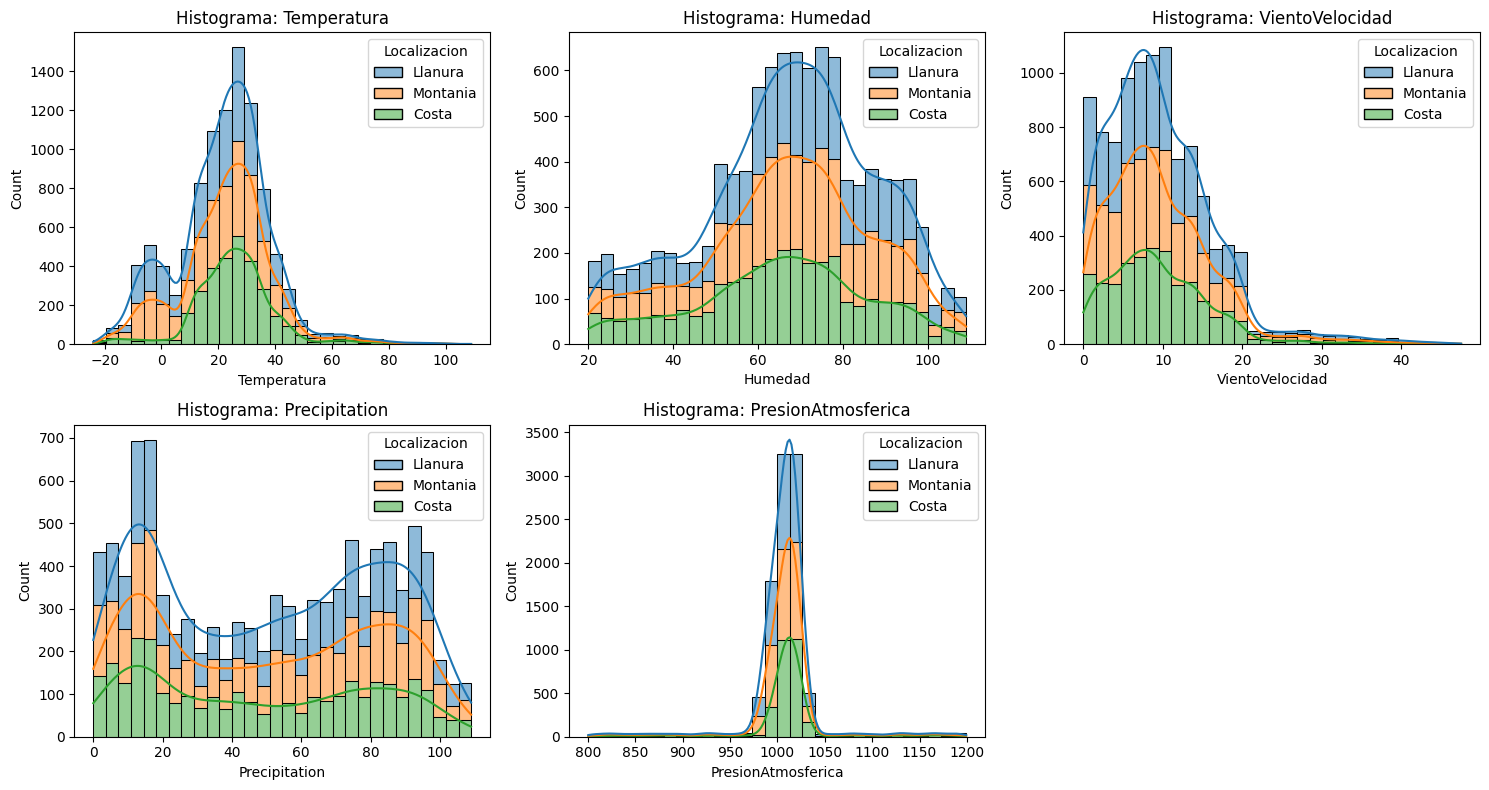

In [58]:
# Hacemos histogramas de las variables numéricas
variables_numericas = ['Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica']

plt.figure(figsize=(15, 8))
for i, columna in enumerate(variables_numericas):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=columna, kde=True, bins=30, color='skyblue', hue='Localizacion', multiple='stack')
    plt.title(f'Histograma: {columna}')
plt.tight_layout()
plt.show()

Se puede observar que:     

**Temperatura** → Distribución aproximadamente normal, ligeramente sesgada hacia la derecha. La mayoría de los valores se concentran entre 20 y 30 °C, con algunos valores extremos más altos.  

**Humedad** → Distribución casi normal, centrada en torno al 70–80 %. Es simétrica y refleja una variabilidad típica de esta variable.

**VientoVelocidad** → Distribución asimétrica positiva. Predominan los valores bajos (0–10 km/h), mientras que los vientos fuertes son poco frecuentes.  

**Precipitation** → Distribución bimodal y no simétrica. Presenta dos picos claros, lo que sugiere diferentes patrones de lluvia, posiblemente estacionales.  

**PresionAtmosferica** → Distribución normal muy concentrada alrededor de 1010 hPa. Tiene poca dispersión y unos pocos valores atípicos en los extremos.

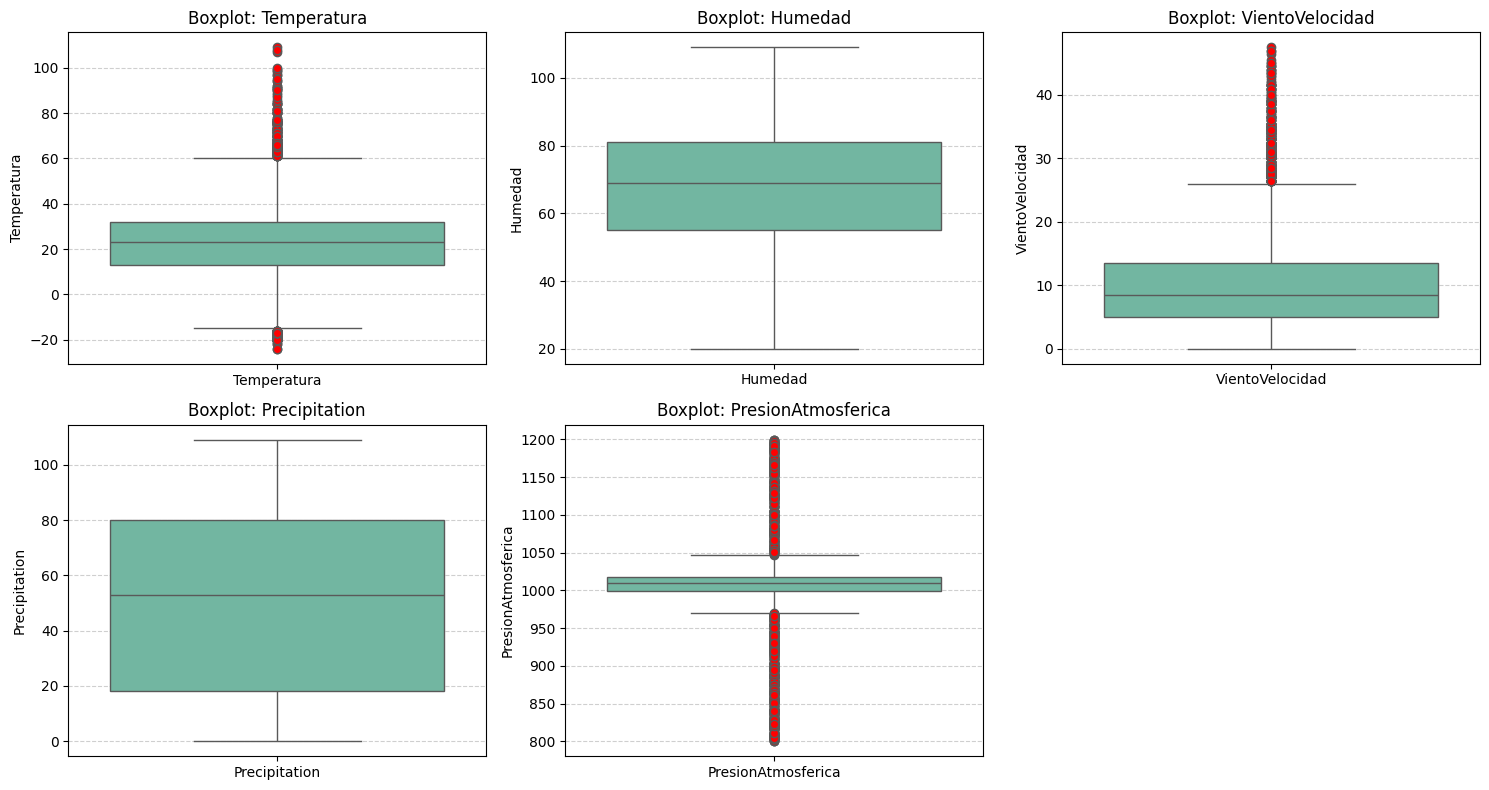

In [7]:
# Crear los subplots
plt.figure(figsize=(15, 8))

for i, columna in enumerate(variables_numericas):
    plt.subplot(2, 3, i + 1)
    
    # Creamos un DataFrame temporal con una columna dummy para evitar el warning
    temp_df = df[[columna]].copy()
    temp_df['Variable'] = columna  # Columna constante, solo para usar como hue
    
    sns.boxplot(
        data=temp_df,
        x='Variable',
        y=columna,
        hue='Variable',
        palette='Set2',
        legend=False,
        flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
    )
    
    plt.title(f'Boxplot: {columna}')
    plt.xlabel('')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Podemos observar que hay outliers en PresionAtmosferica, Temperatura y VientoVelocidad

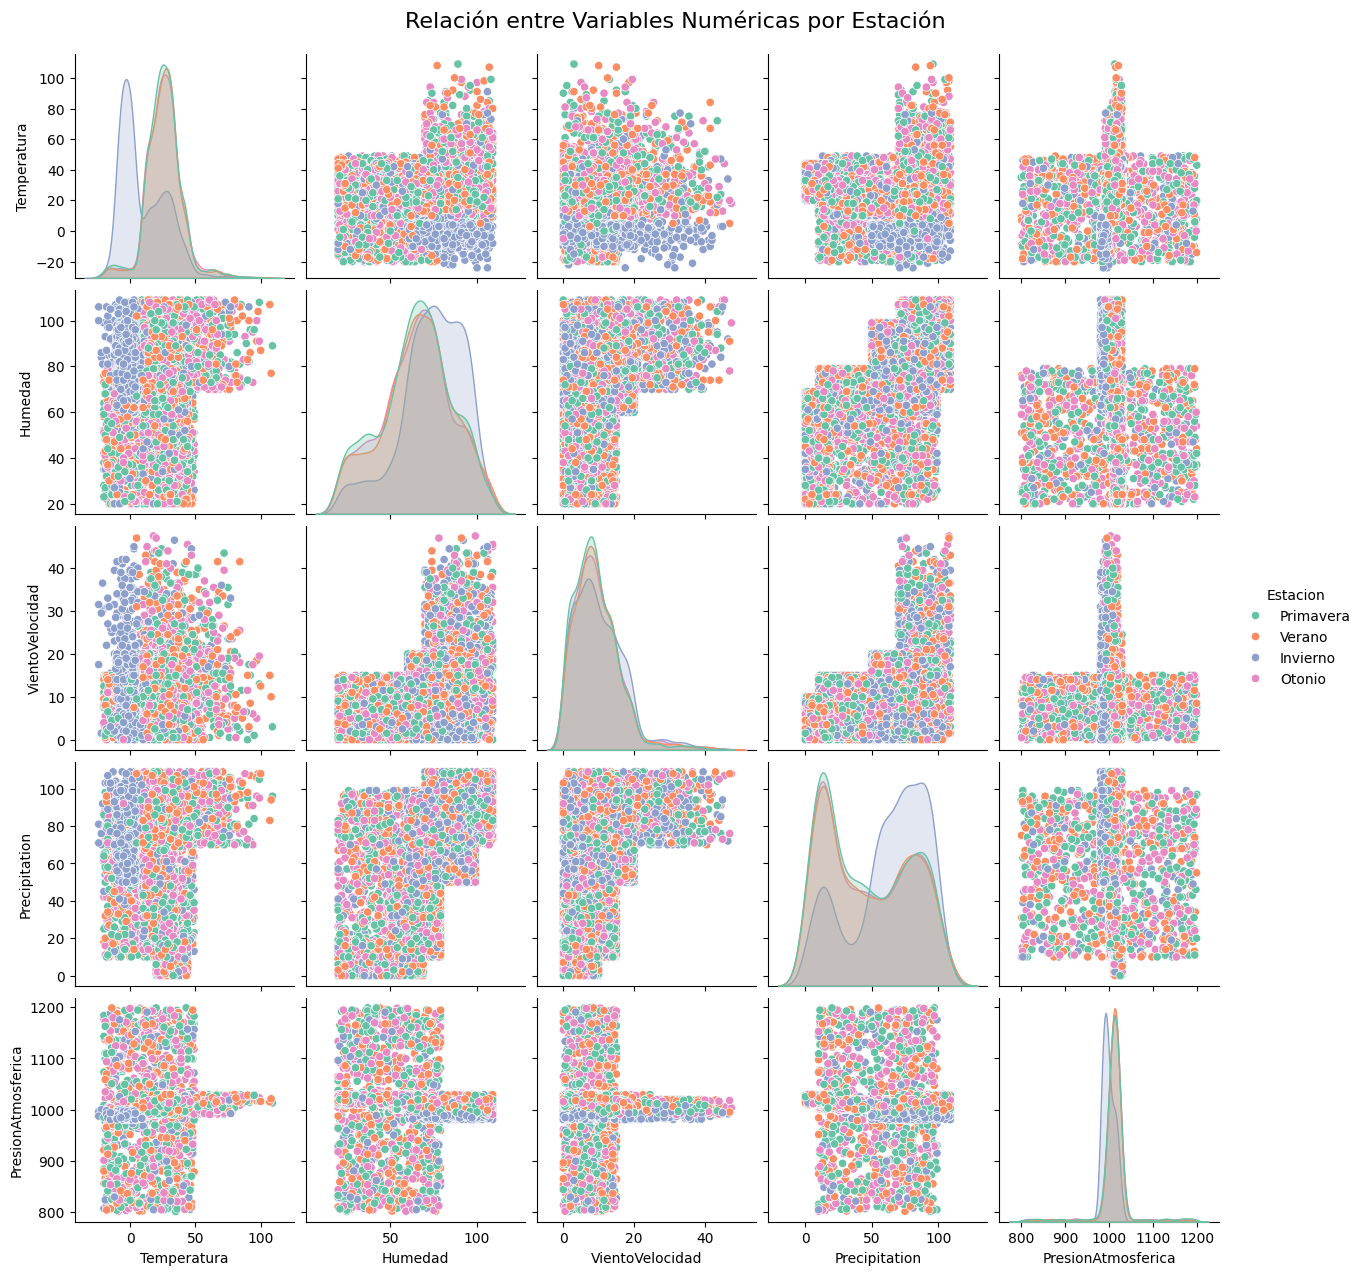

In [72]:
# Pairplot coloreado por Estación
sns.pairplot(df, vars=variables_numericas, hue="Estacion", palette="Set2", diag_kind="kde")
plt.suptitle("Relación entre Variables Numéricas por Estación", y=1.02, fontsize=16)
plt.show()

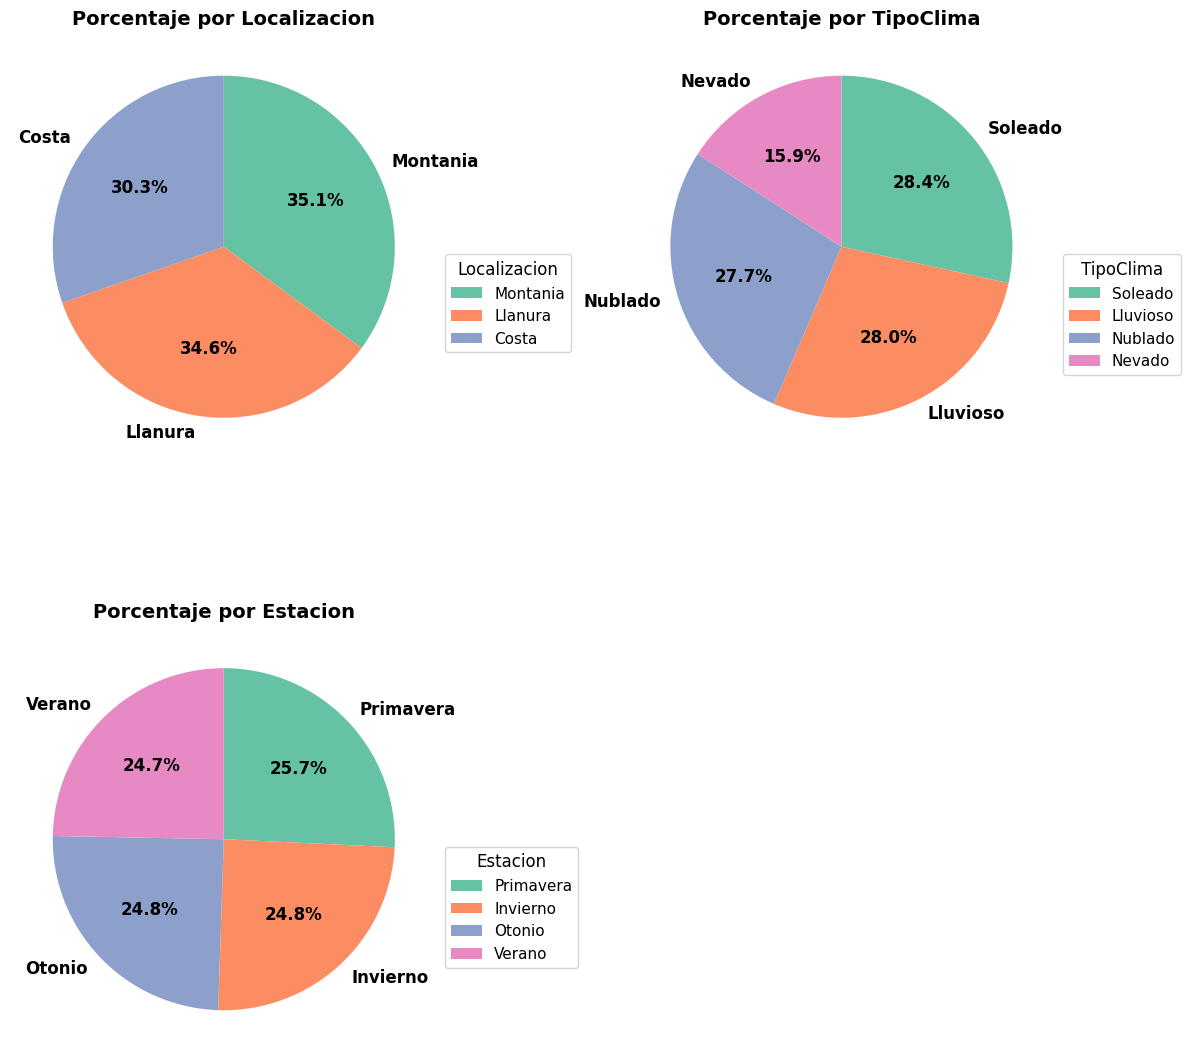

In [86]:
# Lista de variables categóricas
variables_categoricas = ['Localizacion', 'TipoClima', 'Estacion']

palette = 'Set1'

fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2)

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0])
]

for ax, col in zip(axes, variables_categoricas):
    df[col].value_counts().plot.pie(
        ax=ax,
        autopct=lambda pct: f'{pct:.1f}%',
        startangle=90,
        counterclock=False,
        colors=sns.color_palette('Set2', n_colors=df[col].nunique()),
        textprops={'weight': 'bold', 'fontsize': 12}
    )
    ax.set_ylabel('')
    ax.set_title(f'Porcentaje por {col}', fontsize=14, fontweight='bold')
    ax.legend(
        loc='best',
        bbox_to_anchor=(1, 0.5),
        title=f'{col}',
        title_fontsize=12,
        fontsize=11
    )

fig.delaxes(fig.add_subplot(gs[1, 1]))

plt.tight_layout()
plt.show()


Se puede ver que la variable target está balanceada

### Outliers

Dejar Outliers PresionAtmosferica, los de viento se explican por Precipitacion y Humedad, eliminar Outliers Temperatura mayores a 60

In [67]:
# Creamos una copia del DataFrame para filtrar outliers
df_filtrado = df.copy()

# Contador total de filas antes
total_filas = df_filtrado.shape[0]
# Creamos un booleano general para marcar filas con outliers
outliers_mask = pd.Series(False, index=df_filtrado.index)

# Detectamos outliers solo en Temperatura por arriba del rango IQR (Q3 + 1.5*IQR)
Q1_temp = df_filtrado['Temperatura'].quantile(0.25)
Q3_temp = df_filtrado['Temperatura'].quantile(0.75)
IQR_temp = Q3_temp - Q1_temp
limite_superior_temp = Q3_temp + 1.5 * IQR_temp

outliers_mask |= df_filtrado['Temperatura'] > limite_superior_temp

# Mostrar porcentaje de outliers detectados
porcentaje_outliers = (outliers_mask.sum() / total_filas) * 100
print(f"Se detectaron {outliers_mask.sum()} filas con outliers de Temperatura ({porcentaje_outliers:.2f}%)")
df_filtrado = df_filtrado[~outliers_mask].reset_index(drop=True)
print(f"Filas restantes después de eliminar outliers: {df_filtrado.shape[0]}")

Se detectaron 185 filas con outliers de Temperatura (1.83%)
Filas restantes después de eliminar outliers: 9905


In [73]:
df_filtrado.describe()

,Temperatura,Humedad,VientoVelocidad,Precipitation,PresionAtmosferica
count,9905.000000,9905.000000,9905.000000,9905.000000,9905.000000
mean,20.920141,66.791116,9.543009,50.068147,1007.559997
std,14.943958,20.369905,6.704615,32.150593,39.091715
min,-24.000000,20.000000,0.000000,0.000000,800.230000
25%,13.000000,54.000000,5.000000,17.000000,998.360000
50%,23.000000,68.000000,8.500000,52.000000,1010.200000
75%,31.000000,81.000000,13.000000,79.000000,1017.740000
max,60.000000,109.000000,47.500000,109.000000,1199.210000


Eliminamos exclusivamente los valores atípicos de **Temperatura superiores a 60 °C**, dado que el rango posible oscila entre −24 °C y 60 °C.  

En **VientoVelocidad**, descartamos únicamente las mediciones que exceden 30 km/h, ya que el resto de los valores extremos son posibles y están justificados por la Precipitación y la Humedad (Dados por correlaciones positivas de 042 y 0.48 respectivamente).  

Los registros de **PresiónAtmosférica** se mantienen, pues todos los valores observados se encuentran dentro de rangos válidos.

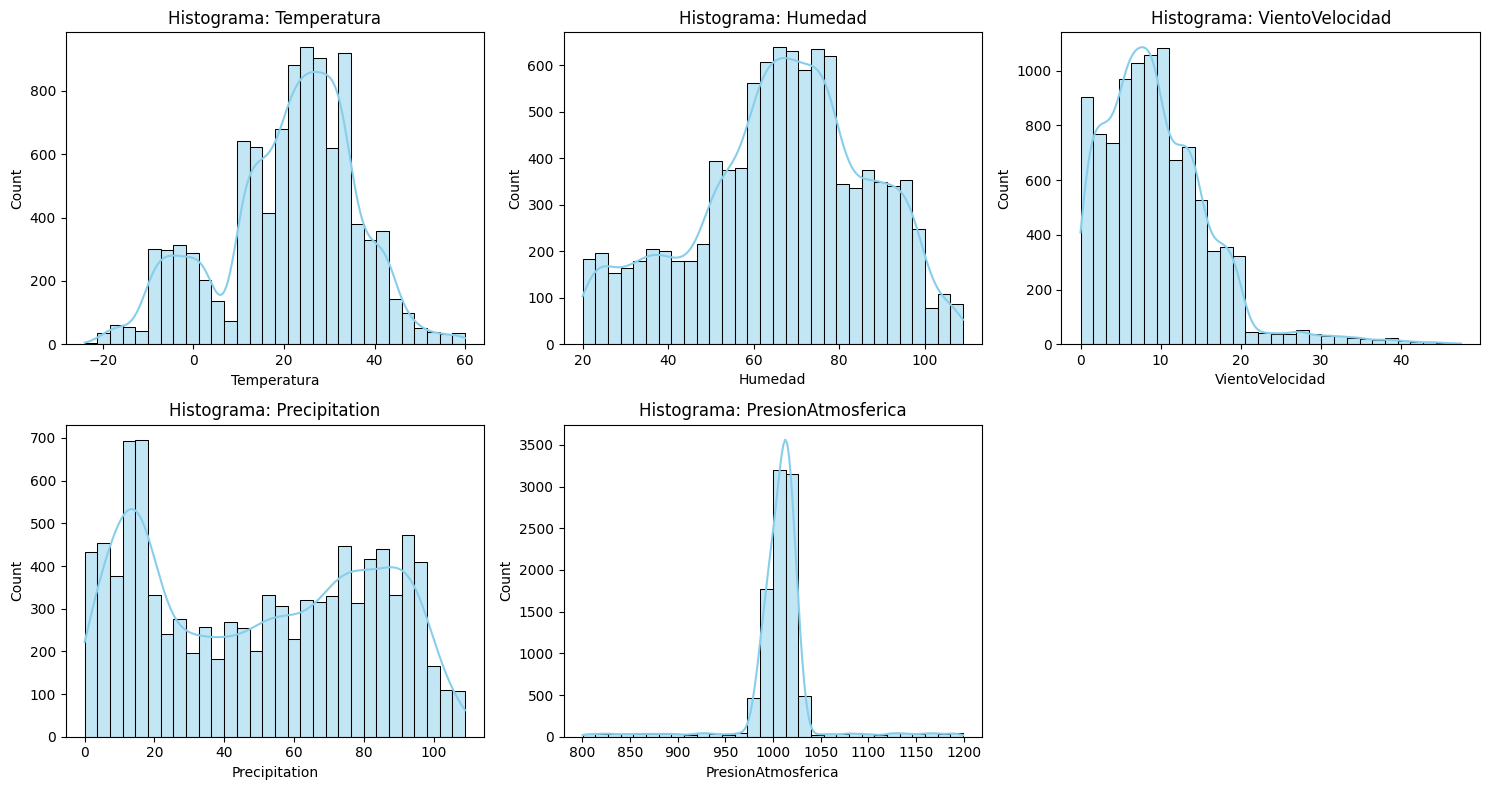

In [68]:
# Vemos como se ven los histogramas de las variables numéricas después de eliminar outliers
plt.figure(figsize=(15, 8))
for i, columna in enumerate(variables_numericas):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df_filtrado, x=columna, kde=True, bins=30, color='skyblue')
    plt.title(f'Histograma: {columna}')
plt.tight_layout()
plt.show()

Se puede observar que, tras eliminar los outliers, las distribuciones se vuelven más limpias y representativas del comportamiento central de los datos.  
Variables como Temperatura y Presión Atmosférica ahora muestran una forma más claramente normal. En VientoVelocidad y Precipitación, se redujo notablemente la asimetría y dispersión, eliminando colas largas y picos extremos. Humedad mantiene su forma general, pero con menor variabilidad en los extremos. En conjunto, las distribuciones se ven más suaves y centradas, facilitando el análisis.

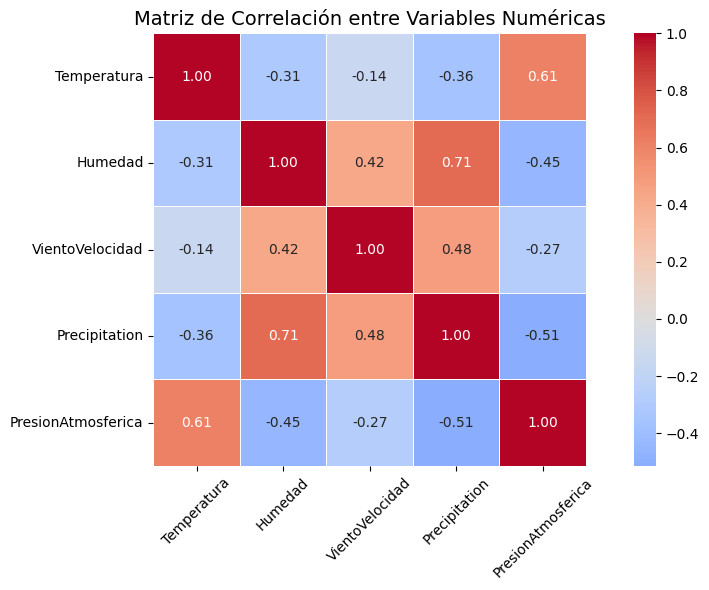

In [12]:
# Calculamos la matriz de correlación
matriz_correlacion = df_filtrado[variables_numericas].corr()

# Visualizamos con un heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', center=0,
            linewidths=0.5, fmt=".2f", square=True)

plt.title("Matriz de Correlación entre Variables Numéricas", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Podemos ver que hay una correlacion positiva fuerte entre Precipitacion y Humedad y entre Temperatura y PresionAtmosferica

### Partición

In [54]:
# Definimos las features relevantes y la variable target
features = [
    'Temperatura', 'Humedad', 'VientoVelocidad', 'Precipitation', 'PresionAtmosferica',
    'Localizacion', 'TipoClima'
]
target = 'Estacion'

# Separamos en conjuntos de entrenamiento y prueba usando únicamente las features definidas (80-20)
X_train, X_test, y_train, y_test = train_test_split(df_filtrado[features], df_filtrado[target], test_size=0.2, random_state=42)


## Ejercicio 2
-------

### Pipeline (Codificación de variables categóricas y escalado de variables continuas)

In [88]:

# Preprocesamiento: OHE para categóricas y escalado para numéricas
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), variables_numericas),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['Localizacion', 'TipoClima'])
])

# Pipeline con SVM lineal
pipeline = Pipeline([
    ('preproc', preprocessor),
    ('svc', SVC(kernel='linear', random_state=42))
])
param_grid = {
    'svc__C': [0.0001, 0.001,  0.01, 1, 10]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)

# Reemplazamos el pipeline por el mejor estimador
pipeline = grid_search.best_estimator_

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred  = pipeline.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Train Precision: {precision_score(y_train, y_train_pred, average='macro'):.3f}")
print(f"Train Recall: {recall_score(y_train, y_train_pred, average='macro'):.3f}")
print(f"Train F1 Score: {f1_score(y_train, y_train_pred, average='macro'):.3f}")
print("--------------------")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"Test F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.3f}")


Best params: {'svc__C': 0.001}
Train Accuracy: 0.398
Train Precision: 0.315
Train Recall: 0.388
Train F1 Score: 0.291
--------------------
Test Accuracy: 0.389
Test Precision: 0.314
Test Recall: 0.395
Test F1 Score: 0.293


/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Las mejores métricas de SVC se consiguieron al **escalar las variables continuas con MinMaxScaler** y ajustar el hiperparámetro **C a 0.001**. 

Este valor de C implica **una regularización fuerte**, penalizando más los errores de clasificación para maximizar el margen y evitar el sobreajuste, a costa de tolerar más fallos en el entrenamiento.  

El rendimiento limitado también puede explicarse por el uso de un kernel lineal, que, al ser más sencillo, no logra modelar relaciones no lineales complejas en los datos.

## Ejercicio 3 - Uso de Kernel Gaussiano
--------

In [89]:
pipeline_gauss = Pipeline([
    ('preproc', preprocessor),
    ('svc', SVC(kernel='rbf', random_state=42))
])
param_grid = {
    'svc__C': [0.0001, 0.001, 0.01, 1, 10],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}

grid_search_g = GridSearchCV(
    pipeline_gauss,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_g.fit(X_train, y_train)

print("Best params:", grid_search_g.best_params_)

# Reemplazamos el pipeline por el mejor estimador
pipeline_gauss = grid_search_g.best_estimator_

pipeline_gauss.fit(X_train, y_train)

y_train_pred = pipeline_gauss.predict(X_train)
y_test_pred  = pipeline_gauss.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Train Precision: {precision_score(y_train, y_train_pred, average='macro'):.3f}")
print(f"Train Recall: {recall_score(y_train, y_train_pred, average='macro'):.3f}")
print(f"Train F1 Score: {f1_score(y_train, y_train_pred, average='macro'):.3f}")
print("--------------------")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred, average='macro'):.3f}")
print(f"Test F1 Score: {f1_score(y_test, y_test_pred, average='macro'):.3f}")

Best params: {'svc__C': 0.01, 'svc__gamma': 1}
Train Accuracy: 0.398
Train Precision: 0.318
Train Recall: 0.388
Train F1 Score: 0.292
--------------------
Test Accuracy: 0.390
Test Precision: 0.317
Test Recall: 0.397
Test F1 Score: 0.294


/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/valentinrosito/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Descripcion 

## Ejercicio 4 - Uso de Random Forest
-------

In [94]:
pipeline_pca = Pipeline([
    ('preproc', preprocessor),
    ('pca', PCA(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'pca__n_components': [2, 3, 4, 5]
}

grid_search_pca = GridSearchCV(
    pipeline_pca,
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_pca.fit(X_train, y_train)
print("Mejores params PCA+SVC:", grid_search_pca.best_params_)

best_pca_svc = grid_search_pca.best_estimator_
y_test_pca = best_pca_svc.predict(X_test)

print(f"PCA+SVC Test Accuracy:   {accuracy_score(y_test, y_test_pca):.3f}")
print(f"PCA+SVC Test Precision:  {precision_score(y_test, y_test_pca, average='macro'):.3f}")
print(f"PCA+SVC Test Recall:     {recall_score(y_test, y_test_pca,    average='macro'):.3f}")
print(f"PCA+SVC Test F1 Score:   {f1_score(y_test, y_test_pca,       average='macro'):.3f}")

Mejores params PCA+SVC: {'pca__n_components': 3, 'rf__max_depth': 10, 'rf__n_estimators': 100}
PCA+SVC Test Accuracy:   0.403
PCA+SVC Test Precision:  0.469
PCA+SVC Test Recall:     0.402
PCA+SVC Test F1 Score:   0.417


Descripcion


### Visualizacion Random Forest

,PC1,PC2,PC3
Temperatura,0.100967,-0.009996,0.034128
Humedad,-0.154556,-0.003080,0.041860
VientoVelocidad,-0.105373,-0.005988,0.053237
Precipitation,-0.234813,-0.001119,0.067239
PresionAtmosferica,0.105786,-0.002510,0.005546
Localizacion_Costa,0.176346,-0.094017,0.386504
Localizacion_Llanura,-0.107441,-0.360331,-0.277909
Localizacion_Montania,-0.068905,0.454348,-0.108596
TipoClima_Lluvioso,-0.259607,-0.026832,0.253191
TipoClima_Nevado,-0.152521,0.038158,-0.133918


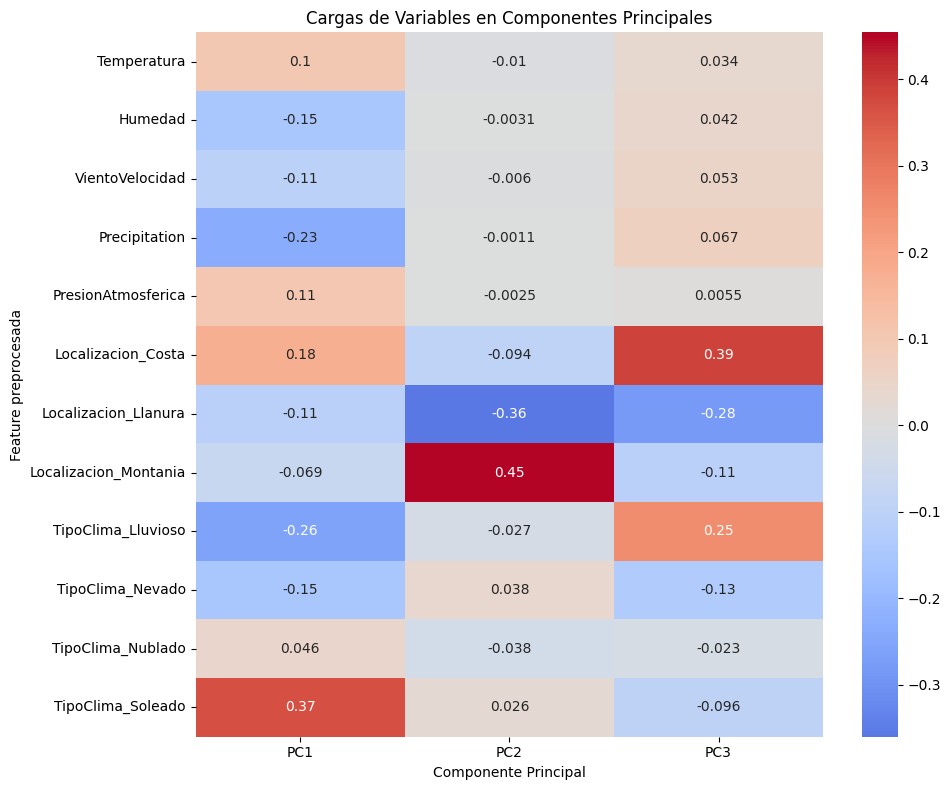

In [98]:
# --- Nueva celda: Cargas de cada variable en los componentes principales (corregido) ---
import numpy as np

# Extraer PCA entrenado y preprocesador
best_pipe = grid_search_pca.best_estimator_
pca       = best_pipe.named_steps['pca']
preproc   = best_pipe.named_steps['preproc']

# 1) Conocer el nombre de cada feature tras el preprocesamiento
num_feats = variables_numericas
cat_feats = preproc.named_transformers_['cat'] \
                   .get_feature_names_out(['Localizacion','TipoClima']) \
                   .tolist()
all_feats = num_feats + cat_feats

# 2) Calcular loadings (componentes * raíz de la varianza explicada)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# 3) Crear DataFrame con índices correctos
pc_names   = [f'PC{i+1}' for i in range(pca.n_components_)]
loading_df = pd.DataFrame(loadings, index=all_feats, columns=pc_names)

# Mostrar los valores numéricos
display(loading_df)

# 4) Heatmap de las cargas
plt.figure(figsize=(10, 8))
sns.heatmap(loading_df, annot=True, cmap='coolwarm', center=0)
plt.title('Cargas de Variables en Componentes Principales')
plt.ylabel('Feature preprocesada')
plt.xlabel('Componente Principal')
plt.tight_layout()
plt.show()

- Agregar matriz de confusion para cada uno 

- SACAR PCA y poner el arbol limitado y que importancia tiene cada variable

- conclusion general

- incluyendo un df que muestre los 3 modelos
